In [1]:
import numpy as np
import os
from tqdm import tqdm
import re
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from keras.layers import MaxPooling2D,Conv2D,Conv2DTranspose,Input,Dropout, BatchNormalization,Concatenate,LeakyReLU
from keras.models import Sequential
from keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras import initializers, optimizers
from keras import Model

(150, 150, 3)


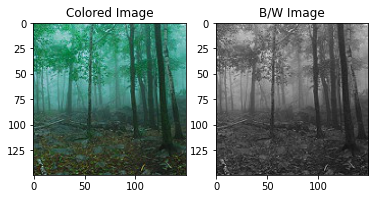

(150, 150, 3)


In [2]:
ran = np.random.randint(7000)
img = load_img('../input/landscape-image-colorization/landscape Images/color/'+str(ran)+'.jpg')
plt.subplot(121)
plt.imshow(img)
plt.title('Colored Image')
print(img_to_array(img).shape)

img = load_img('../input/landscape-image-colorization/landscape Images/gray/'+str(ran)+'.jpg')
plt.subplot(122)
plt.imshow(img)
plt.title('B/W Image')
plt.show()
print(img_to_array(img).shape)

In [3]:
# to get the files in proper order
def sorted_alphanumeric(data):  
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)

In [4]:
bw_img = []
path = '../input/landscape-image-colorization/landscape Images/gray'
files = os.listdir(path)
files = sorted_alphanumeric(files)
print('No. of b/w images', str(len(files)))
for file in tqdm(files):
    img = load_img(path + '/'+file, target_size=(150,150))
    img = img_to_array(img)/255.
    bw_img.append(img)
    
color_img =[]
path = '../input/landscape-image-colorization/landscape Images/color'
files = os.listdir(path)
files = sorted_alphanumeric(files)
print('No. of colored images', str(len(files)))
for file in tqdm(files):
    img = load_img(path + '/'+file, target_size=(150,150))
    img = img_to_array(img)/255.
    color_img.append(img)
    
color_img = np.array(color_img)
bw_img = np.array(bw_img)

No. of b/w images 7129


100%|██████████| 7129/7129 [00:35<00:00, 199.00it/s]


No. of colored images 7129


100%|██████████| 7129/7129 [00:38<00:00, 185.81it/s]


In [6]:
init_k = initializers.HeNormal(seed=23)
init_b = initializers.HeNormal(seed=37)

model = Sequential()
model.add(Conv2D(64, (4,4), (2,2),  input_shape=(150,150,3), activation='relu',
                 kernel_initializer=init_k, bias_initializer=init_b))
model.add(BatchNormalization())

model.add(Conv2D(128, (4,4), (2,2), activation='relu',
                 kernel_initializer=init_k, bias_initializer=init_b))
model.add(BatchNormalization())

model.add(Conv2D(156, (3,3), (2,2), padding='same',activation='relu',
                 kernel_initializer=init_k, bias_initializer=init_b))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Conv2D(284, (3,3), (2,2), padding='same',kernel_initializer=init_k, bias_initializer=init_b))
model.add(Dropout(0.45))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.07))

model.add(Conv2D(512, (3,3), (2,2), padding='same',kernel_initializer=init_k, bias_initializer=init_b))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.07))



model.add(Conv2DTranspose(512, (3,3), (1,1), padding='valid',
                          kernel_initializer=init_k, bias_initializer=init_b))
model.add(Dropout(0.35))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Conv2DTranspose(256, (3,3), (1,1), padding='valid',
                          kernel_initializer=init_k, bias_initializer=init_b))
model.add(Dropout(0.4))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Conv2DTranspose(156, (3,3), (2,2), padding='same',
                          kernel_initializer=init_k, bias_initializer=init_b))
model.add(Dropout(0.35))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(Conv2DTranspose(128, (3,3), (2,2), padding='same', activation='relu',
                          kernel_initializer=init_k, bias_initializer=init_b))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Conv2DTranspose(64, (4,4), (2,2), padding='valid', activation='relu',
                          kernel_initializer=init_k, bias_initializer=init_b))
model.add(BatchNormalization())
model.add(Conv2DTranspose(3, (4,4), (2,2), padding='valid', activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 74, 74, 64)        3136      
_________________________________________________________________
batch_normalization_10 (Batc (None, 74, 74, 64)        256       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 36, 36, 128)       131200    
_________________________________________________________________
batch_normalization_11 (Batc (None, 36, 36, 128)       512       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 18, 18, 156)       179868    
_________________________________________________________________
dropout_7 (Dropout)          (None, 18, 18, 156)       0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 18, 18, 156)      

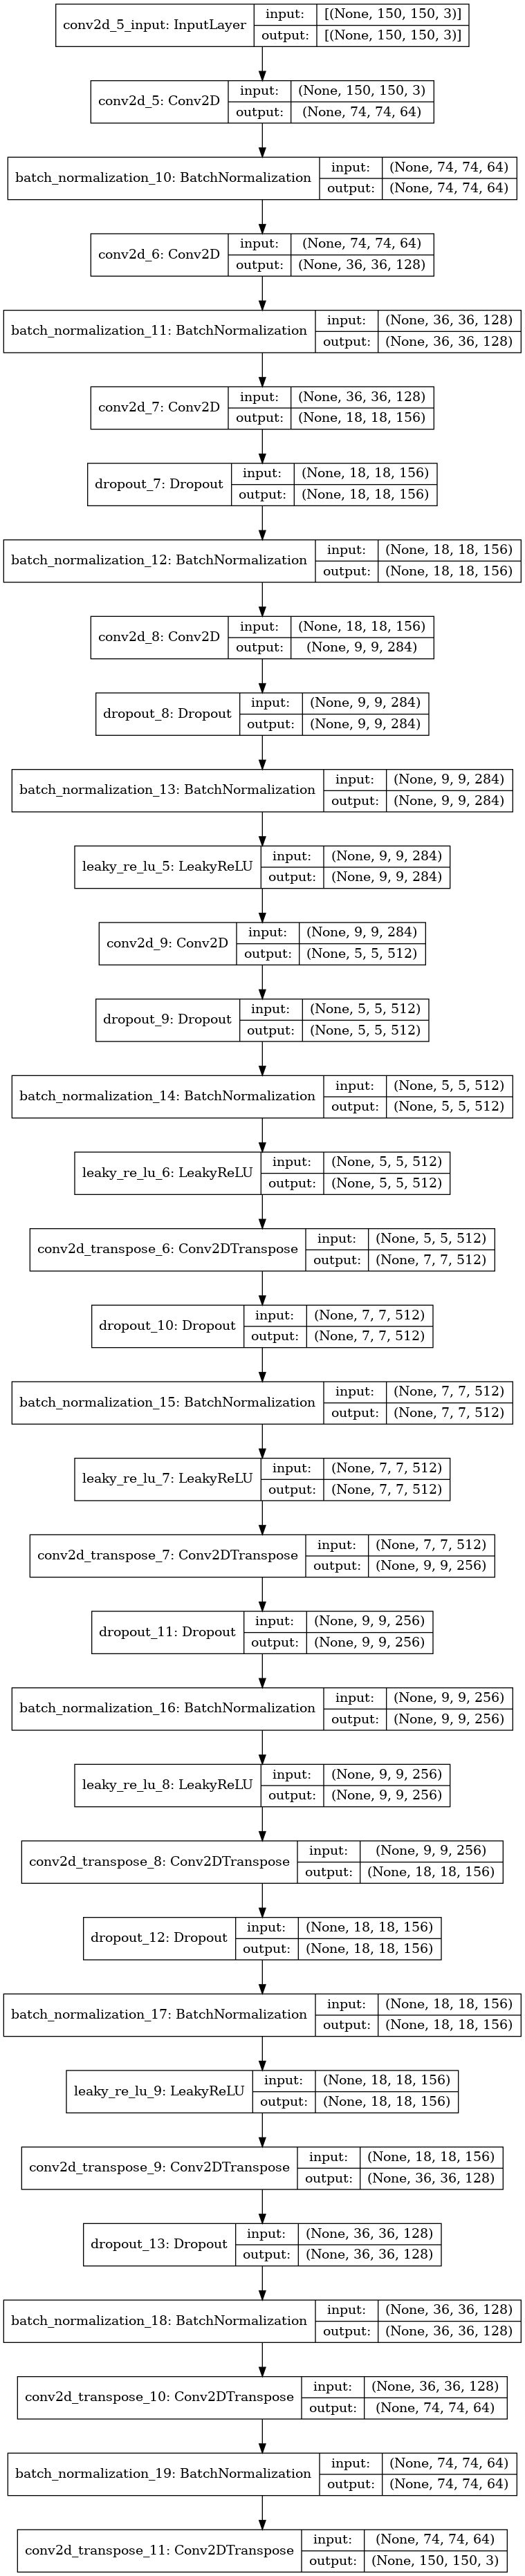

In [7]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [8]:
c_train, c_test =color_img[:5000], color_img[5000:]
g_train, g_test =bw_img[:5000], bw_img[5000:]

In [9]:
model.compile(loss=['mean_squared_error','mean_absolute_error'],
              optimizer=optimizers.Adam(learning_rate=0.0002),metrics = ['acc'])
his = model.fit(g_train, c_train, epochs=100, batch_size = 64,
                validation_data=(g_test, c_test))

2022-06-27 20:00:28.790329: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1350000000 exceeds 10% of free system memory.
2022-06-27 20:00:29.745474: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1350000000 exceeds 10% of free system memory.
2022-06-27 20:00:30.873243: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1350000000 exceeds 10% of free system memory.
2022-06-27 20:00:31.134294: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1350000000 exceeds 10% of free system memory.
2022-06-27 20:00:32.130932: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-06-27 20:00:34.386031: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


79/79 [==============================] - ETA: 0s - loss: 0.0656 - acc: 0.3600

2022-06-27 20:00:47.666163: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 574830000 exceeds 10% of free system memory.


79/79 [==============================] - 18s 121ms/step - loss: 0.0656 - acc: 0.3600 - val_loss: 0.0737 - val_acc: 0.3950
Epoch 2/100
79/79 [==============================] - 8s 102ms/step - loss: 0.0419 - acc: 0.4167 - val_loss: 0.0528 - val_acc: 0.4468
Epoch 3/100
79/79 [==============================] - 8s 104ms/step - loss: 0.0374 - acc: 0.4280 - val_loss: 0.0435 - val_acc: 0.4434
Epoch 4/100
79/79 [==============================] - 8s 101ms/step - loss: 0.0351 - acc: 0.4308 - val_loss: 0.0402 - val_acc: 0.4449
Epoch 5/100
79/79 [==============================] - 8s 102ms/step - loss: 0.0337 - acc: 0.4346 - val_loss: 0.0371 - val_acc: 0.4483
Epoch 6/100
79/79 [==============================] - 8s 101ms/step - loss: 0.0326 - acc: 0.4357 - val_loss: 0.0360 - val_acc: 0.4521
Epoch 7/100
79/79 [==============================] - 8s 105ms/step - loss: 0.0320 - acc: 0.4430 - val_loss: 0.0350 - val_acc: 0.4539
Epoch 8/100
79/79 [==============================] - 8s 101ms/step - loss: 0.031

In [17]:
def plott():
    n = np.random.randint(1000)
    pred = model.predict(g_train[n].reshape((1,150,150,3)))
    print(n)
    plt.figure(figsize=(20,10))

    plt.subplot(131)
    plt.imshow(g_train[n])
    plt.title('Grey')

    plt.subplot(132)
    plt.imshow(c_train[n])
    plt.title('Color')

    plt.subplot(133)
    plt.imshow(pred[0])
    plt.title('Predicted')

789
400
531
185


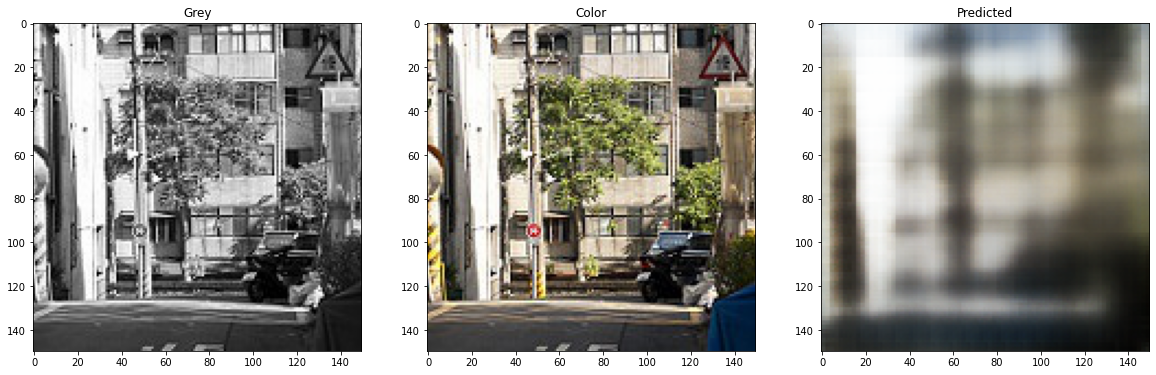

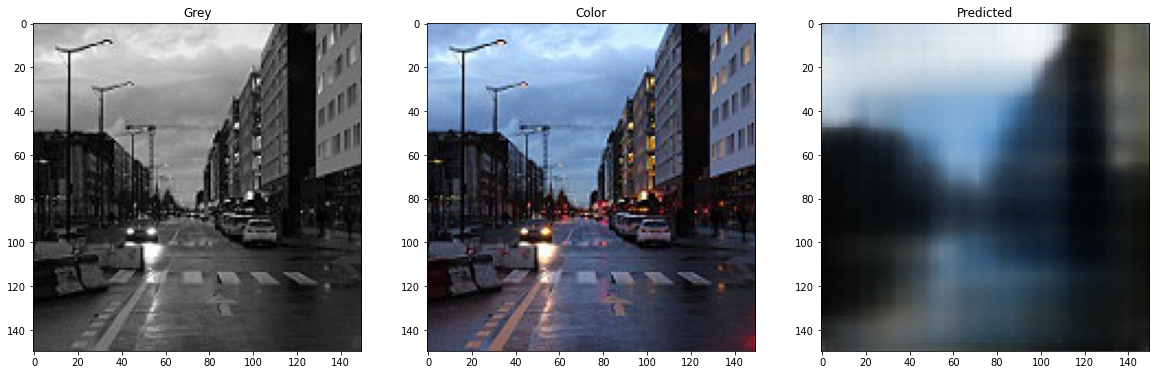

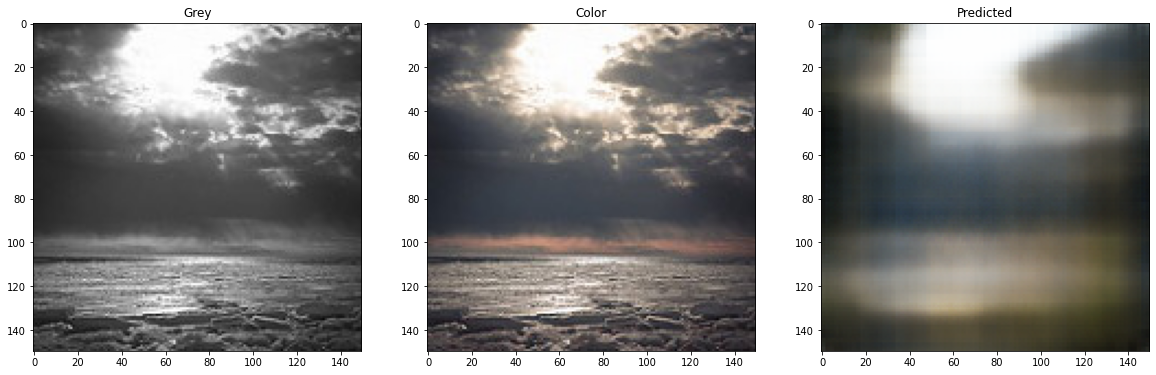

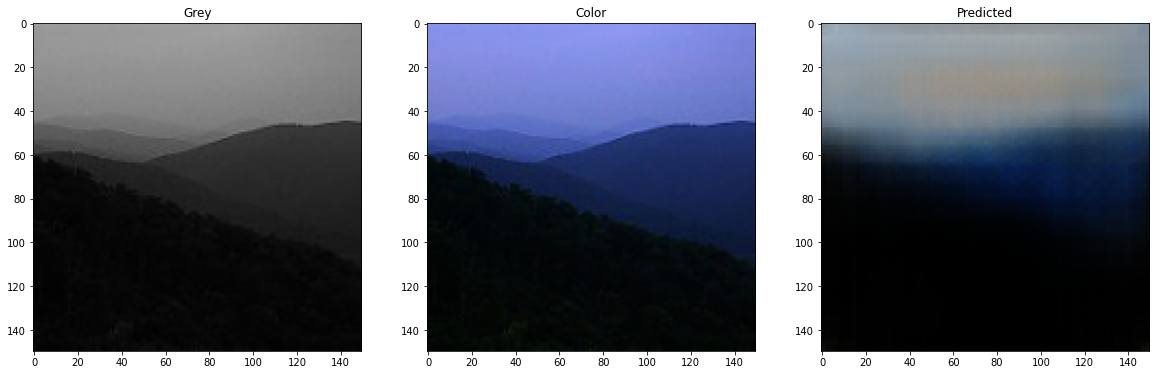

In [18]:
for i in range(4):
    plott()

In [ ]:
from tensorflow.keras.backend import clear_session
del model
clear_session()